from hugginface : https://huggingface.co/learn/cookbook/advanced_rag but applied to our corpus

In [1]:
from tqdm import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_core.documents import Document

from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer



In [2]:
#EMBEDDING_MODEL_NAME = "thenlper/gte-small"
EMBEDDING_MODEL_NAME = "thenlper/gte-large"
#EMBEDDING_MODEL_NAME = "dangvantuan/sentence-camembert-large"
#EMBEDDING_MODEL_NAME = "dangvantuan/sentence-camembert-base"

In [3]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

In [4]:

#loader = TextLoader("corpus/afrique/au-senegal-une-tiktokeuse-qui-vendait-des-boulettes-pour-faire-grossir-les-fesses-poursuivie.txt")
text_loader_kwargs = {"autodetect_encoding": True}
loader = DirectoryLoader("corpus/", glob='**/**/*.txt', loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
docs = loader.load()

In [5]:
docs_processed = []
for doc in docs:
    docs_processed += text_splitter.split_documents([doc])

Model's maximum sequence length: 512


100%|██████████| 505/505 [00:00<00:00, 2040.97it/s]


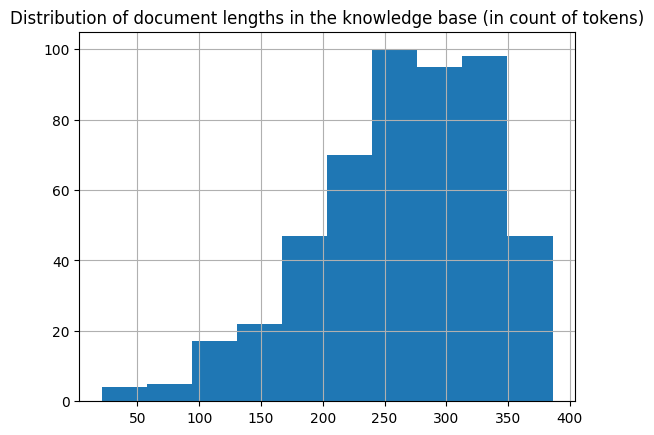

In [6]:
# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
model_max_length = SentenceTransformer('thenlper/gte-small').max_seq_length
print(f"Model's maximum sequence length: {model_max_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [7]:
def split_documents(
    chunk_size: int,
    knowledge_base: List[Document],
    tokenizer,
) -> List[Document]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

docs_processed = split_documents(
    model_max_length,
    docs,
    tokenizer,
)

100%|██████████| 351/351 [00:00<00:00, 1380.33it/s]


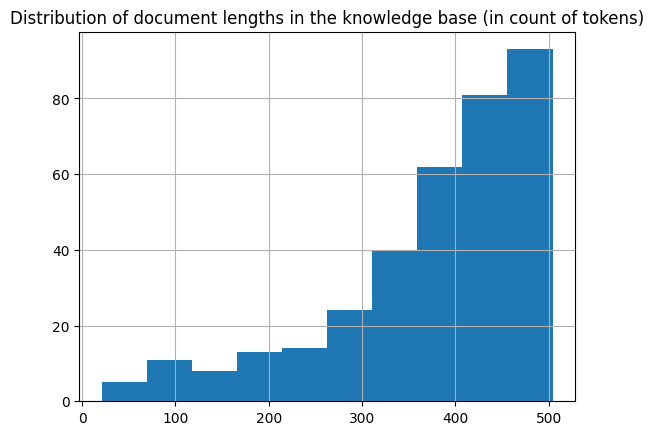

In [8]:

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [9]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

vector_database = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

C:\Users\Ohmatheus\AppData\Local\Temp\ipykernel_4928\3932242158.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [10]:
user_query = "Trump"
query_vector = embedding_model.embed_query(user_query)

In [11]:
import pacmap
import numpy as np
import plotly.express as px


embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(vector_database.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [12]:
docs_processed

[Document(metadata={'source': 'corpus\\afrique\\au-burkina-faso-la-prison-a-vie-pour-deux-personnes-impliquees-dans-une-attaque-a-ouagadougou-en-2017.txt', 'start_index': 0}, page_content='Au BurkinaÂ\xa0Faso, la prison Ã\xa0 vie pour deux personnes impliquÃ©es dans une attaque Ã\xa0 Ouagadougou enÂ\xa02017\nDeux personnes impliquÃ©es dans une attaque djihadiste contre un cafÃ©, qui avait fait 19Â\xa0morts en aoÃ»tÂ\xa02017 Ã\xa0 Ouagadougou, ont Ã©tÃ© condamnÃ©es Ã\xa0 la prison Ã\xa0 vie par la justice du Burkina Faso. Â«Â\xa0Deux prÃ©venus (â€¦) ont Ã©tÃ© jugÃ©s lors dâ€™une session du mois de novembre et condamnÃ©s Ã\xa0 lâ€™emprisonnement Ã\xa0 vieÂ\xa0Â», Ã©crit le pÃ´le judiciaire spÃ©cialisÃ© dans la rÃ©pression des actes terroristes dans un communiquÃ©, consultÃ© jeudi 2Â\xa0janvier par lâ€™Agence France-Presse.\nCes deux personnes avaient Ã©tÃ© interpellÃ©es au cours dâ€™une intervention antiterroriste en maiÂ\xa02018 dans le quartier de Rayongo Ã\xa0 Ouagadougou, Ã\xa0 la su

In [13]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            #"source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    #color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [14]:
user_query = "boulette faire grossir fesses afrique"
query_vector = embedding_model.embed_query(user_query)

In [15]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = vector_database.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='boulette faire grossir fesses afrique'...

==================================Top document==================================
Au SÃ©nÃ©gal, une tiktokeuse qui vendait des Â«Â boulettesÂ Â» pour faire grossir les fesses poursuivie
Alima Sow est en passe de devenir lâ€™une des tiktokeuses les plus connues du SÃ©nÃ©gal, mais elle doit moins sa soudaine popularitÃ© Ã  ses talents dâ€™influenceuse quâ€™Ã  la diligence des autoritÃ©s de son pays. Vendeuse de produits cosmÃ©tiques en ligne et sur le marchÃ© de Pikine, dans la banlieue de la capitale sÃ©nÃ©galaise, la commerÃ§ante est poursuivie pour Â«Â mise en danger de la vie dâ€™autrui, exercice illÃ©gal de la profession de pharmacien et administration de substances nuisibles Ã  la santÃ© publiqueÂ Â». Parmi les produits qui ont retenu lâ€™attention des mÃ©dias et de la justice figuraient les dÃ©sormais fameuses Â«Â boulettes pour fessesÂ Â», sorte de suppositoires promettant des courbes gÃ©nÃ©reuses Ã  ce

In [16]:
retrieved_docs

[Document(id='cf3157ec-e92d-4246-b723-a4390753f1ae', metadata={'source': 'corpus\\afrique\\au-senegal-une-tiktokeuse-qui-vendait-des-boulettes-pour-faire-grossir-les-fesses-poursuivie.txt', 'start_index': 0}, page_content='Au SÃ©nÃ©gal, une tiktokeuse qui vendait des Â«Â\xa0boulettesÂ\xa0Â» pour faire grossir les fesses poursuivie\nAlima Sow est en passe de devenir lâ€™une des tiktokeuses les plus connues du SÃ©nÃ©gal, mais elle doit moins sa soudaine popularitÃ© Ã\xa0 ses talents dâ€™influenceuse quâ€™Ã\xa0 la diligence des autoritÃ©s de son pays. Vendeuse de produits cosmÃ©tiques en ligne et sur le marchÃ© de Pikine, dans la banlieue de la capitale sÃ©nÃ©galaise, la commerÃ§ante est poursuivie pour Â«Â\xa0mise en danger de la vie dâ€™autrui, exercice illÃ©gal de la profession de pharmacien et administration de substances nuisibles Ã\xa0 la santÃ© publiqueÂ\xa0Â». Parmi les produits qui ont retenu lâ€™attention des mÃ©dias et de la justice figuraient les dÃ©sormais fameuses Â«Â\xa0bou

# DeepSeek

In [17]:
#READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
#READER_MODEL_NAME  = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

In [18]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [19]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
#model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [20]:
llm = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.1,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=2000,
)

Device set to use cuda:0


In [21]:
gen = llm("Quel est le resultat de (4+4)*5-58 ? Enleve les markdowns de ta réponse.")

In [22]:
answer = gen[0]["generated_text"]
print(answer)

 Si vous avez du hasard, please provide the answer in a python code.

</think>

Pour résoudre l'expression \((4 + 4) \times 5 - 58\), suivons les étapes suivantes :

1. **Calculer la somme dans les parentheses :**
   \[
   4 + 4 = 8
   \]

2. **Multipliez le résultat par 5 :**
   \[
   8 \times 5 = 40
   \]

3. **Entracte 58 du résultat de l' multiplication :**
   \[
   40 - 58 = -18
   \]

**Résultat final :** \(-18\)


In [23]:
#At the end, provide the links of the source documents. 
#Feel free to add any information that may be related, even distantly, to the topic of the question. 

#Using only the information given in context, try to make a full detailed report of the news in the scope of the prompt. 
#Becarefull, the documents in the context are possibly not related to the prompt, and thus should be ignored.
#Only use the information in the context if related to the prompt. 
#Give extensive details only if you can. 
#Stay in the scope of the prompt. The prompt is very important. If you don't find enought information related to the scope, don't make a report.
#If a document don't have any related information with the prompt, ignore the document.
#If you have enought information, structure the response by regrouping and categorizing the information related to the prompt, into topics. 
#Explain context of information if you can. 
#At the end, provide the links of the source documents. 
#The answer must be in english, don't translate in french.
#If the answer cannot be deduced from the context, say that you do not know.

#Structure the response from selected document into topics. Be very specific.

In [38]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """
For each document in context, try to retreive information related to the user's subject, and select document that are relevant.
If there is no explicit link between a document and the subject, ignore this document.
If you don't have enought information to make a report based on the subject, say that you can't make a report.
Then, If you have enought information, make a very detailed news report with the information from selected documents. 

Context:
{context}

""",
    },
    {
        "role": "user",
        "content": """
---
Now, here are the subjects from which you should build your news reports.

subject: {subject}. """,
    },
]

rag_prompt_template = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(rag_prompt_template)

<｜begin▁of▁sentence｜>
For each document in context, try to retreive information related to the user's subject, and select document that are relevant.
If there is no explicit link between a document and the subject, ignore this document.
If you don't have enought information to make a report based on the subject, say that you can't make a report.
Then, If you have enought information, make a very detailed news report with the information from selected documents. 

Context:
{context}

<｜User｜>
---
Now, here is the subject(s) from which you should build your news reports.

subject: {subject}. <｜Assistant｜>


In [39]:
question = "Trump"
user_query = question
query_vector = embedding_model.embed_query(user_query)
retrieved_docs = vector_database.similarity_search_with_score(query=user_query, k=10)

In [40]:
retrieved_docs

[(Document(id='cf3157ec-e92d-4246-b723-a4390753f1ae', metadata={'source': 'corpus\\afrique\\au-senegal-une-tiktokeuse-qui-vendait-des-boulettes-pour-faire-grossir-les-fesses-poursuivie.txt', 'start_index': 0}, page_content='Au SÃ©nÃ©gal, une tiktokeuse qui vendait des Â«Â\xa0boulettesÂ\xa0Â» pour faire grossir les fesses poursuivie\nAlima Sow est en passe de devenir lâ€™une des tiktokeuses les plus connues du SÃ©nÃ©gal, mais elle doit moins sa soudaine popularitÃ© Ã\xa0 ses talents dâ€™influenceuse quâ€™Ã\xa0 la diligence des autoritÃ©s de son pays. Vendeuse de produits cosmÃ©tiques en ligne et sur le marchÃ© de Pikine, dans la banlieue de la capitale sÃ©nÃ©galaise, la commerÃ§ante est poursuivie pour Â«Â\xa0mise en danger de la vie dâ€™autrui, exercice illÃ©gal de la profession de pharmacien et administration de substances nuisibles Ã\xa0 la santÃ© publiqueÂ\xa0Â». Parmi les produits qui ont retenu lâ€™attention des mÃ©dias et de la justice figuraient les dÃ©sormais fameuses Â«Â\xa0bo

In [41]:
retrieved_docs_text = [doc[0].page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nDocuments :\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = rag_prompt_template.format(context=context, subject=question)

# Redact an answer
llm_answer = llm(final_prompt)

In [42]:
answer = llm_answer[0]["generated_text"]
print(answer)

<think>
Alright, I need to help the user by creating a news report based on their query about TikTok fessels in Senegal. Let me start by understanding what they're asking for. They provided several documents discussing various topics related to TikTok, including its impact on fashion, social media trends, and specific cases of influencers engaging in violent acts. The main subject is "boulette tiktok fesses senegal," which translates to TikTok fakes in Senegal.

First, I'll look through the provided documents to find relevant information. Document 0 talks about TikTok's business model and its use of fake products, specifically mentioning the TikTok Group brand. This seems directly related to the topic since it discusses how TikTok uses fake fakes to generate revenue.

Document 1 discusses TikTok's TikTok and TikTok Plus services, focusing on their features like photos and videos. While not directly about fakes, it might provide context on how TikTok operates in general, which could be 